In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, average_precision_score
from sklearn.inspection import permutation_importance
import os
import joblib
import pickle
import json
import glob
url = "https://raw.githubusercontent.com/Walfeinick/dpo-walfeinick-rep/main/data/S06-hw-dataset-04.csv"
data = pd.read_csv(url)

print(data.head())
print(f"\n информация о датасете")
print(data.info())
print(f"\n Описание")
print(data.describe())
print(f"\n Распределение таргета:")
print(data['target'].value_counts(normalize=True)) #вывод распределения

os.makedirs('artifacts', exist_ok=True)

   id       f01       f02       f03       f04       f05       f06       f07  \
0   1 -1.250210  1.423474 -0.225004 -4.023138 -0.832729 -0.550874  1.772090   
1   2  0.074328  0.376429  0.212831 -0.502074  2.017405  0.625496  1.943785   
2   3  0.638481  0.060968  0.746760  2.479653 -0.292858 -0.078139 -2.918423   
3   4  1.712916 -1.350969 -0.256473  1.622074 -0.445141  0.911932 -3.440345   
4   5  0.905676 -0.206545 -0.068806  4.086026 -1.010045 -0.772644 -4.207688   

        f08       f09  ...        f52        f53       f54       f55  \
0  2.761690 -0.698750  ...  10.938269   0.501178  1.600001  0.314212   
1  1.242030 -0.524090  ...   7.775262  -4.550195  6.272586 -0.932162   
2 -0.013186  1.009135  ...  -4.448447  -9.593179 -3.093519  0.029321   
3  1.505192 -1.104348  ...  -1.619072  -3.237479 -5.474038 -1.582475   
4  2.506104  1.589143  ...  -2.396844 -10.540129 -5.532811 -1.231203   

        f56       f57       f58       f59       f60  target  
0  1.209735  1.355697 -5.33892

In [3]:
X = data.drop(columns = ['id', 'target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Фиксированный сид и стратифакция важны для возможности воспроизведения результата

In [14]:
#Создаем бейслайны
baseline1 = DummyClassifier(strategy ="most_frequent", random_state=42 )
baseline1.fit(X_train, y_train)
y_predicted_base1 = baseline1.predict(X_test)
y_proba_base1 = baseline1.predict_proba(X_test)[:,1]
accuracy_dumb = accuracy_score(y_test, y_predicted_base1)
roc_auc_dumb = roc_auc_score(y_test, y_proba_base1)


pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter= 1000, random_state=42))
])
baseline2 = pipe;
baseline2.fit(X_train, y_train)
y_predicted_base2 = baseline2.predict(X_test)
y_proba_base2 = baseline2.predict_proba(X_test)[:,1]
accuracy_linreg = accuracy_score(y_test, y_predicted_base2)
roc_auc_linreg = roc_auc_score(y_test, y_proba_base2)

print("Оценка DummyClassifier:")
print(f"Strategy: 'most_frequent' (всегда предсказывает самый частый класс)")
print(f"Accuracy на тесте: {accuracy_dumb:.3f}")
print(f"ROC-AUC на тесте: {roc_auc_dumb:.3f}")
print("\nОценка LinearRegression:")
print(f"Accuracy на тесте: {accuracy_linreg:.3f}")
print(f"ROC-AUC на тесте: {roc_auc_linreg:.3f}")



Оценка DummyClassifier:
Strategy: 'most_frequent' (всегда предсказывает самый частый класс)
Accuracy на тесте: 0.951
ROC-AUC на тесте: 0.500

Оценка LinearRegression:
Accuracy на тесте: 0.963
ROC-AUC на тесте: 0.834


In [26]:
def model_res(model, X_test, y_test, model_name):
  pred = model.predict(X_test)
  proba = None
  if hasattr(model, "predict_proba"):
    proba = model.predict_proba(X_test)[:, 1]
  acc = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  print(f"accuracy = {acc:.4f}")
  print(f"f1       = {f1:.4f}")
  if proba is not None:
    try:
      auc = roc_auc_score(y_test, proba)
      print(f"roc_auc  = {auc:.4f}")
    except Exception:
      pass
  print("confusion_matrix:")
  conf_matrix = confusion_matrix(y_test, pred)
  print(conf_matrix)
  print()
  try:
    save_metrics(model_name, acc, f1, auc, conf_matrix)
  except Exception:
      print('Can not save model metrics')
  return proba

In [29]:
#Сохранение лучшей модели
def save_model(model, path, filename='best_model.joblib'):
  filepath = os.path.join(path, filename)
  joblib.dump(model, filepath)
  method = 'joblib'
  print(f"Модель сохранена: {filepath}")

##def save_search_summaries():

def save_best_model_meta():
  metadata = {'created_at': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
              'test_set_size': len(y_test),
              'metrics_computed': metrics_list,
              'models_count': len(models_dict)}


#Сохранение метрик
def save_metrics(model_name, accuracy, f1, roc_auc, confusion_matrix, path='artifacts'):
  metrics={'accuracy': accuracy, 'f1_score': f1, 'ROC_AUC': roc_auc, 'confusion_matrix': confusion_matrix}
  filename=f'{model_name}_metrics_test.json'
  json_path = os.path.join(path, filename)
  with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
  print(f"metrics for {model_name} saved in {filename}")

#Все метрики в 1 файл
def merge_metrics(folder_path, output_file='metrics_test.json'):
  all_metrics = {}
  json_files = glob.glob(os.path.join(folder_path, '*_metrics_test.json'))
  for file_path in json_files:
    try:
      with open(file_path, 'r', encoding='utf-8') as f:
        metrics = json.load(f)

      filename = os.path.basename(file_path)
      model_name = filename.replace('_metrics_test.json', '')
      all_metrics[model_name] = metrics

    except Exception as e:
      print(f"Ошибка при чтении файла {file_path}: {e}")

  # Сохраняем объединенный файл
  output_path = os.path.join(folder_path, output_file)
  with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(all_metrics, f, indent=2, ensure_ascii=False)


#Сохранение графика
def save_figure(fig, filename, path, dpi=300, **kwargs):
  filepath = os.path.join(path, filename)
  fig.savefig(filepath, dpi=dpi, **kwargs)
  print(f"График сохранен: {filepath}")

In [ ]:
def model_res_with_cv(model, X_train, y_train, X_test, y_test, model_name="Model"):
  print(f"MODEL: {model_name}")
  print()
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  cv_auc_scores = cross_val_score(model, X_train, y_train,
                                  cv=cv, scoring='roc_auc', n_jobs=-1)
  cv_f1_scores = cross_val_score(model, X_train, y_train,
                                cv=cv, scoring='f1', n_jobs=-1)

  print("CROSS-VALIDATION (5-fold):")
  print(f"  ROC-AUC: {cv_auc_scores.mean():.4f} (±{cv_auc_scores.std():.4f})")
  print(f"  F1-Score: {cv_f1_scores.mean():.4f} (±{cv_f1_scores.std():.4f})")

  #Обучение на полном train и оценка на test
  model.fit(X_train, y_train)

  pred = model.predict(X_test)
  proba = None
  if hasattr(model, "predict_proba"):
    proba = model.predict_proba(X_test)[:, 1]
  acc = accuracy_score(y_test, pred)
  f1 = f1_score(y_test, pred)

  print("\nTEST SET PERFORMANCE:")
  print(f"  Accuracy = {acc:.4f}")
  print(f"  F1       = {f1:.4f}")
  if proba is not None:
    try:
      auc = roc_auc_score(y_test, proba)
      print(f"  ROC-AUC  = {auc:.4f}")
      # Разница между CV и тестом
      cv_test_gap = cv_auc_scores.mean() - auc
      print(f"\nCV-Test ROC-AUC gap: {cv_test_gap:+.4f}")
      if abs(cv_test_gap) > 0.03:
          status = "OVERFITTING" if cv_test_gap < -0.03 else "UNDERFITTING"
          print(f"{status} (gap > 0.03)")

    except Exception as e:
      print(f"  ROC-AUC calculation failed: {e}")

  print("\nConfusion Matrix:")
  print(confusion_matrix(y_test, pred))
  return {
    'cv_auc_mean': cv_auc_scores.mean(),
    'cv_auc_std': cv_auc_scores.std(),
    'cv_f1_mean': cv_f1_scores.mean(),
    'cv_f1_std': cv_f1_scores.std(),
    'test_acc': acc,
    'test_f1': f1,
    'test_auc': auc if 'auc' in locals() else None,
    'y_proba': proba
  }

In [6]:
#Обучение моделей

#Tree
model_tree = DecisionTreeClassifier(max_depth=10, min_samples_leaf=20, random_state=42)
model_tree.fit(X_train, y_train)
#Random Forest
model_rf = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
model_rf.fit(X_train, y_train)
#Boosting
model_gb = GradientBoostingClassifier( n_estimators=300, learning_rate=0.05, max_depth=2, random_state=42)
model_gb.fit(X_train, y_train)
#Stacking
estimators = [
    ("lr", Pipeline([("scaler", StandardScaler()), ("lr", LogisticRegression(max_iter=2000))])),
    ("rf", RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)),
    ("gb", GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=2, random_state=42)),
]
final_est = LogisticRegression(max_iter=2000)
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=final_est,
    cv=5,
    n_jobs=-1,
    passthrough=False
)
stack.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('lr',
                                                 LogisticRegression(max_iter=2000))])),
                               ('rf',
                                RandomForestClassifier(n_estimators=250,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=2,
                                                           n_estimators=250,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=2000),
                   n_jobs=-1)

In [30]:
tree_proba = model_res(model_tree, X_test, y_test, 'model_tree')

rf_proba = model_res(model_rf, X_test, y_test, 'model_rf')

gb_proba = model_res(model_gb, X_test, y_test, 'model_gb')

stack_proba = model_res(stack, X_test, y_test, 'stack')

accuracy = 0.9676
f1       = 0.5825
roc_auc  = 0.8319
confusion_matrix:
[[4725   29]
 [ 133  113]]

Can not save model metrics
accuracy = 0.9742
f1       = 0.6466
roc_auc  = 0.9008
confusion_matrix:
[[4753    1]
 [ 128  118]]

Can not save model metrics
accuracy = 0.9718
f1       = 0.6137
roc_auc  = 0.8918
confusion_matrix:
[[4747    7]
 [ 134  112]]

Can not save model metrics
accuracy = 0.9790
f1       = 0.7445
roc_auc  = 0.9024
confusion_matrix:
[[4742   12]
 [  93  153]]

Can not save model metrics


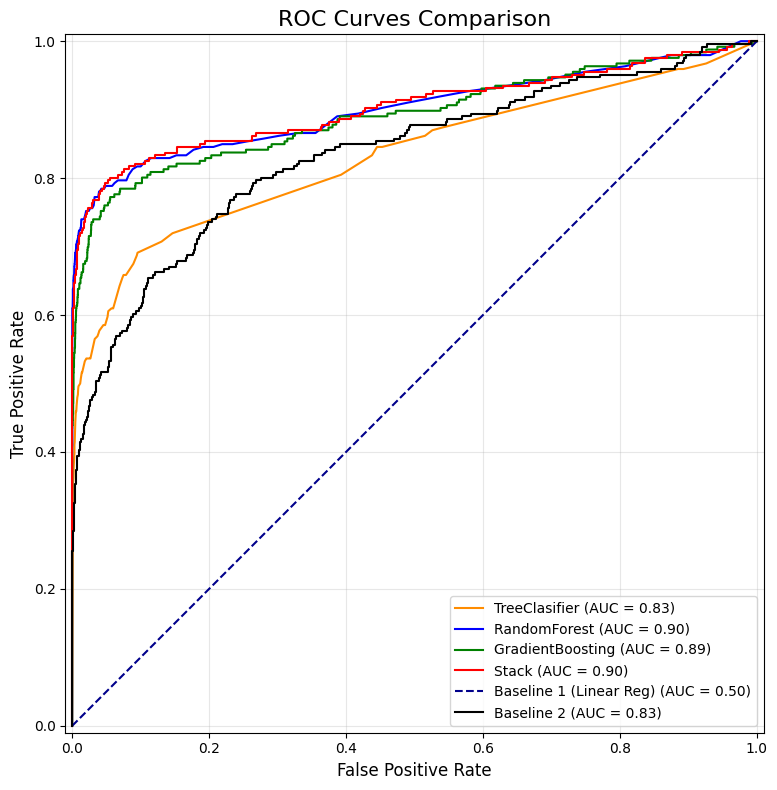

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

# Список моделей, их предсказаний и стилей
models_info = [
    {"name": "TreeClasifier", "y_proba": tree_proba, "color": "darkorange", "linestyle": "-"},
    {"name": "RandomForest", "y_proba": rf_proba, "color": "blue", "linestyle": "-"},
    {"name": "GradientBoosting", "y_proba": gb_proba, "color": "green", "linestyle": "-"},
    {"name": "Stack", "y_proba": stack_proba, "color": "red", "linestyle": "-"},
    {"name": "Baseline 1 (Linear Reg)", "y_proba": y_proba_base1, "color": "darkblue", "linestyle": "--"},
    {"name": "Baseline 2", "y_proba": y_proba_base2, "color": "black", "linestyle": "-"}
]

for model_info in models_info:
    RocCurveDisplay.from_predictions(
        y_test,
        model_info["y_proba"],
        name=model_info["name"],
        color=model_info["color"],
        linestyle=model_info["linestyle"],
        ax=ax
    )
ax.set_title('ROC Curves Comparison', fontsize=16)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

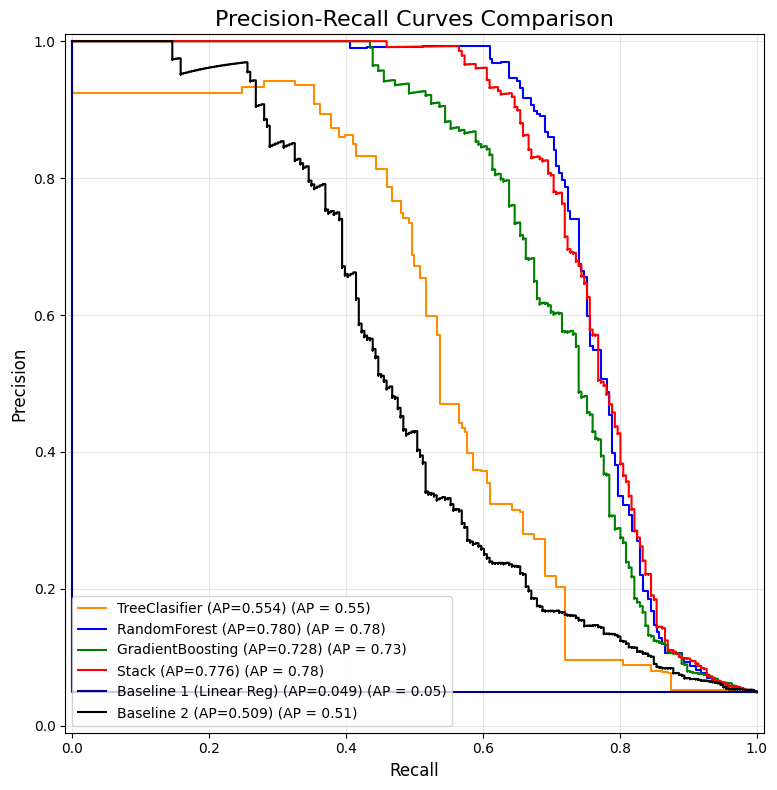

In [9]:

fig, ax = plt.subplots(figsize=(10, 8))

# Список моделей и их предсказаний
models_info = [
    {"name": "TreeClasifier", "y_proba": tree_proba, "color": "darkorange"},
    {"name": "RandomForest", "y_proba": rf_proba, "color": "blue"},
    {"name": "GradientBoosting", "y_proba": gb_proba, "color": "green"},
    {"name": "Stack", "y_proba": stack_proba, "color": "red"},
    {"name": "Baseline 1 (Linear Reg)", "y_proba": y_proba_base1, "color": "darkblue"},
    {"name": "Baseline 2", "y_proba": y_proba_base2, "color": "black"}
]

for model_info in models_info:
    PrecisionRecallDisplay.from_predictions(
        y_test,
        model_info["y_proba"],
        name=f"{model_info['name']} (AP={average_precision_score(y_test, model_info['y_proba']):.3f})",
        color=model_info["color"],
        ax=ax
    )
ax.set_title('Precision-Recall Curves Comparison', fontsize=16)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.legend(loc="lower left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
def calculate_permutation_importance(model, X_test, y_test, feature_names=None,
                                     scoring='roc_auc', n_repeats=10,
                                     random_state=42, top_n=12):
  if feature_names is None:
    if hasattr(X_test, 'columns'):
      feature_names = X_test.columns.tolist()
  print(f"Model: {model.__class__.__name__}")
  print(f"Scoring metric: {scoring}")
  print(f"Number of repeats: {n_repeats}")
  # Вычисляем permutation importance
  result = permutation_importance(
    estimator=model,
    X=X_test,
    y=y_test,
    scoring=scoring,
    n_repeats=n_repeats,
    random_state=random_state,
    n_jobs=-1  # параллельные вычисления
  )
  # Создаем DataFrame с результатами
  importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
  })
    # Сортируем по убыванию важности
  importance_df = importance_df.sort_values('importance_mean', ascending=False)
  # Показываем топ-N признаков
  print(f"\nTop-{top_n} Most Important Features:\n")
  for i, row in enumerate(importance_df.head(top_n).itertuples(), 1):
    print(f"{i:2d}. {row.feature:<30} importance = {row.importance_mean:.4f} ± {row.importance_std:.4f}")
  return result

# Считаем permutation importance
result = calculate_permutation_importance(model=stack, X_test=X_test, y_test=y_test)

Model: StackingClassifier
Scoring metric: roc_auc
Number of repeats: 10

Top-12 Most Important Features:

 1. f54                            importance = 0.0172 ± 0.0041
 2. f53                            importance = 0.0124 ± 0.0052
 3. f25                            importance = 0.0120 ± 0.0039
 4. f04                            importance = 0.0103 ± 0.0031
 5. f13                            importance = 0.0101 ± 0.0033
 6. f58                            importance = 0.0087 ± 0.0062
 7. f08                            importance = 0.0073 ± 0.0042
 8. f33                            importance = 0.0070 ± 0.0036
 9. f41                            importance = 0.0057 ± 0.0040
10. f11                            importance = 0.0051 ± 0.0031
11. f38                            importance = 0.0048 ± 0.0021
12. f52                            importance = 0.0046 ± 0.0019
